In [1]:
import simdata
import matplotlib.pyplot as pl
import casatasks
import casatools
import numpy as np

In [2]:
%load_ext autoreload

In [3]:
def showimage(image):
    # load image
    ia = casatools.image()
    ia.open(image)

    # summarize image
    dd = ia.summary()
    npixx,npixy,nch,npol = dd['shape']
    print('Image shape: {0}'.format(dd['shape']))
    imvals = ia.getchunk(0, int(npixx))[:,:,0,0]
    peakx, peaky = np.where(imvals.max() == imvals)
    print('Peak SNR at pix ({0},{1}) = {2}'.format(peakx[0], peaky[0], imvals.max()/imvals.std()))
#    print('Beam shape: {0}'.format(ia.history()[1].split('\n')[10].split(':')[5]))
    
    pl.figure(figsize=(15,8))
    pl.imshow(imvals.transpose(), interpolation='nearest', origin='bottom')
    pl.colorbar()

    return imvals

In [14]:
msname='dsa110-calsrc.ms'
imagebase = 'first'
srcdirection="J2000 12h00m00.0s 50d00m00.0s"
caldirection=None

In [15]:
simdata.gensources(complist='cal.cl', caldirection=caldirection, calflux=1.0,
                   srcdirection=srcdirection, srcflux=1.0,
                   freq='1.4GHz')

2019-09-26 17:25:46,347 - simdata - INFO - Removing existing file, cal.cl


AssertionError: {'dir': ['null value not allowed']}

In [16]:
simdata.simulate(msname=msname, calobsdir=caldirection, srcobsdir=srcdirection,
                 freq='1.4GHz', integrationtime='1s', diameter=5.0, noise='0Jy',
                 gainnoise=0,
#                 imagename='first_12h+50d.ms',
                 complist='cal.cl')

2019-09-26 17:26:06,284 - simdata - INFO - Removing existing file, dsa110-calsrc.ms


In [20]:
def read(msname='dsa110-calsrc.ms'):
    """ Read simulated ms and return data                                                                                                                                         
    """

    ms = casatools.ms()
    ms.open('dsa110-calsrc.ms')
    dd = ms.getdata(items=['data', 'axis_info', 'uvw'], ifraxis=True)
    print(dd.keys())
    data = dd['data']
#    times = dd['axis_info']['time_axis']['MJDseconds']                                                                                                                           
#    plt.plot(data[...,0].flatten().real, data[...,0].flatten().imag, '.')                                                                                                        
    return data


In [21]:
data = read(msname=msname)

dict_keys(['axis_info', 'data', 'uvw'])


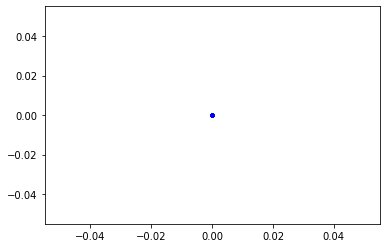

In [22]:
pl.plot(data.flatten().real, data.flatten().imag, 'b.') 

In [6]:
casatasks.tclean(vis=msname, imagename=imagebase, field='cal', spw='0', cell='2arcsec', imsize=2048, datacolumn='data')

{}

Image shape: [7200 7200    1    1]
Peak SNR at pix (255,2475) = 839.5050001537638


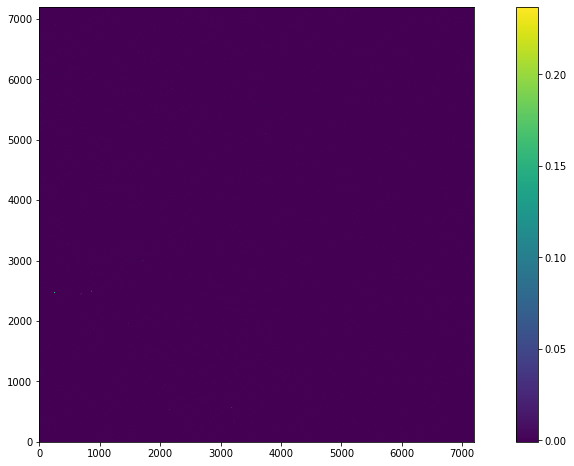

In [8]:
image = showimage('first_12h+50d.ms')

In [38]:
def transit(direction, integration, num):
    i = 0
    while i < num:
        epoch, ra, dec = direction.split(' ')
        hh, mm, ss = ra.replace('h', ' ').replace('m', ' ')[:-1].split()
        ss = float(ss) + float(integration)
        ra = '{0}h{1}m{2}s'.format(hh, mm, ss)
        direction = ' '.join([epoch, ra, dec])
        yield direction
        i += 1